In [38]:
import os, json
import numpy as np
import pandas as pd
%matplotlib inline

In [39]:
from libcbmwrapper import LibCBMWrapper
import libcbmconfig
import cbm_defaults
dllpath = r'C:\dev\LibCBM\LibCBM\x64\Debug\LibCBM.dll'
dbpath = 'C:\dev\cbm_defaults\cbm_defaults.db'
dlldir = os.path.dirname(dllpath)
cwd = os.getcwd()
os.chdir(dlldir)
dll = LibCBMWrapper(dllpath)
os.chdir(cwd)

In [40]:
import cbm3_python_helper
cbm3_python_helper.load_cbm3_python()
import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import sit_helper
from cbm3_python.cbm3data import cbm3_results
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()

In [41]:
classifier_name = "growth_curve"
n_steps = 300

age_interval = 10 #required by cbm3
num_age_classes = 20 #required by cbm3
def get_classifier_name(id):
    return "growth_curve_{0}".format(id)
def create_growth_curve(id, admin_boundary, eco_boundary, softwood_species=None, 
                        softwood_age_volume_pairs=None, hardwood_species=None, 
                        hardwood_age_volume_pairs=None):
    return {
        "id":id,
        "admin_boundary": admin_boundary,
        "eco_boundary": eco_boundary,
        "softwood_species": softwood_species,
        "softwood_age_volume_pairs": softwood_age_volume_pairs,
        "hardwood_species": hardwood_species,
        "hardwood_age_volume_pairs": hardwood_age_volume_pairs
    }
cases = [create_growth_curve(1, "British Columbia", "Pacific Maritime", "Spruce", [ (0, 0.0),
                    (10, 10.0),
                    (20, 15.0),
                    (30, 20.0),
                    (40, 25.0),
                    (50, 30.0),
                    (60, 35.0),
                    (70, 40.0),
                    (80, 45.0),
                    (90, 50.0),
                    (100, 55.0),
                    (110, 60.0),
                    (120, 65.0),
                    (130, 70.0),
                    (140, 75.0),
                    (150, 80.0),
                    (160, 85.625),
                    (170, 90.73529412),
                    (180, 95.84558824),
                    (190, 100.9558824)] )]

In [55]:
def run_libCBM(dbpath, cases):



    #create a single classifier/classifier value for the single growth curve
    classifiers_config = libcbmconfig.classifier_config([
        libcbmconfig.classifier("growth_curve", [
            libcbmconfig.classifier_value(get_classifier_name(c["id"])) 
            for c in cases
        ])
    ])


    transitions_config = []
    species_reference = cbm_defaults.load_species_reference(dbpath, "en-CA")
    spatial_unit_reference =cbm_defaults.get_spatial_unit_ids_by_admin_eco_name(dbpath, "en-CA")
    curves = []
    for c in cases:
        softwood_species_id = None
        softwood_age_volume_pairs = None
        hardwood_species_id = None
        hardwood_age_volume_pairs = None
        if c["softwood_species"]:
            softwood_species_id = species_reference[c["softwood_species"]]["species_id"]
            softwood_age_volume_pairs = c["softwood_age_volume_pairs"]
        if c["hardwood_species"]:
            hardwood_species_id = species_reference[c["hardwood_species"]]["species_id"]
            hardwood_age_volume_pairs = c["hardwood_age_volume_pairs"]

        curve = libcbmconfig.merch_volume_curve(
            classifier_set = [get_classifier_name(c["id"])],
            softwood_species_id = softwood_species_id,
            softwood_age_volume_pairs = softwood_age_volume_pairs,
            hardwood_species_id = hardwood_species_id,
            hardwood_age_volume_pairs = hardwood_age_volume_pairs)
        curves.append(curve)

    merch_volume_to_biomass_config = libcbmconfig.merch_volume_to_biomass_config(
        dbpath, curves)

    config = libcbmconfig.initialize_config(
        dbpath = dbpath,
        merch_volume_to_biomass = merch_volume_to_biomass_config,
        classifiers = classifiers_config,
        transitions = [])

    dll.Initialize(libcbmconfig.to_string(config))

    nstands = len(cases)
    age = np.zeros(nstands,dtype=np.int32)
    classifiers = np.array(
        [classifiers_config["classifier_index"][0][get_classifier_name(c["id"])]
         for c in cases], dtype=np.int32)
    spatial_units = np.array(
        [spatial_unit_reference[(c["admin_boundary"],c["eco_boundary"])]
            for c in cases],dtype=np.int32)

    pools = np.zeros((nstands,len(config["pools"])))
    pools[:,0] = 1.0

    op = dll.AllocateOp(nstands)

    result = pd.DataFrame()
    for i in range(0, n_steps):
        dll.GetMerchVolumeGrowthOps(
            op, 
            classifiers=classifiers,
            pools=pools,
            ages=age,
            spatial_units=spatial_units,
            last_dist_type=None,
            time_since_last_dist=None,
            growth_multipliers=None)

        #since growth in CBM3 is split into 2 phases, we need to apply the operation 2 times
        dll.ComputePools([op, op], pools)

        iteration_result = pd.DataFrame({x["name"]: pools[:,x["index"]] for x in config["pools"]})
        iteration_result.reset_index(level=0, inplace=True)
        result = result.append(iteration_result)

        age += 1

    result = result.reset_index(drop=True)
    return result

In [56]:
libCBM_result = run_libCBM(dbpath, cases)

In [44]:
toolbox_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3"

cbm3_project_dir = os.path.join(toolbox_path, "Projects", "libcbm_growth_curve_testing")
cbm3_project_path = os.path.join(cbm3_project_dir, "libcbm_growth_curve_testing.mdb")
config_save_path = os.path.join(cbm3_project_dir, "libcbm_growth_curve_testing.json")
sit_config = sit_helper.SITConfig(
    imported_project_path=cbm3_project_path,
    initialize_mapping=True
)
sit_config.data_config(
    age_class_size=age_interval,
    num_age_classes=num_age_classes,
    classifiers=["admin", "eco", "identifier", "species"])
sit_config.set_admin_eco_mapping("admin","eco")
sit_config.set_species_classifier("species")
for c in cases:
    cset = [c["admin_boundary"], c["eco_boundary"], get_classifier_name(c["id"]), "Spruce"]
    sit_config.add_inventory(classifier_set=cset, area=1, age=0, unfccc_land_class=0,
                    historic_disturbance="Wildfire", last_pass_disturbance="Wildfire")
    if c["softwood_species"]:
        sit_config.add_yield(classifier_set=cset, 
                    leading_species_classifier_value=c["softwood_species"],
                    values=[x[1] for x in c["softwood_age_volume_pairs"]])
    if c["hardwood_species"]:
        sit_config.add_yield(classifier_set=cset, 
                    leading_species_classifier_value=c["softwood_species"],
                    values=[x[1] for x in c["softwood_age_volume_pairs"]])
sit_config.add_event(
    classifier_set=["?","?","?","?"],
    disturbance_type="Wildfire",
    time_step=n_steps+1,
    target=1,
    target_type = "Area",
    sort = "SORT_BY_SW_AGE")
sit_config.import_project(standard_import_tool_plugin_path, config_save_path)
results_db_path = cbm3_python.simulation.projectsimulator.run(
    aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb"), 
    project_path=cbm3_project_path, 
    toolbox_installation_dir=toolbox_path,
    cbm_exe_path=os.path.join(toolbox_path, "admin", "executables"))

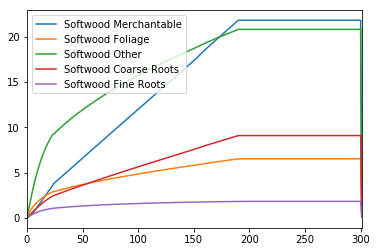

In [50]:

pool_indicators = cbm3_results.load_pool_indicators(results_db_path)
pool_indicators[[ 
    'Softwood Merchantable',
 'Softwood Foliage',
 'Softwood Other',
 'Softwood Coarse Roots',
 'Softwood Fine Roots'
 #'Hardwood Merchantable',
 #'Hardwood Foliage',
 #'Hardwood Other',
 #'Hardwood Coarse Roots',
 #'Hardwood Fine Roots'
                ]].plot()

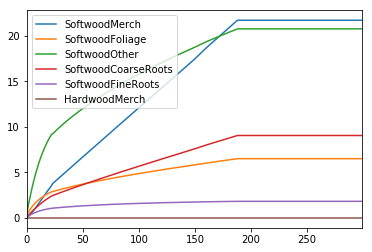

In [57]:
libCBM_result[['SoftwoodMerch',
 'SoftwoodFoliage',
 'SoftwoodOther',
 'SoftwoodCoarseRoots',
 'SoftwoodFineRoots',
 'HardwoodMerch']].plot()